## Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from optbinning.scorecard import plot_auc_roc, plot_ks
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression

import warnings

import joblib

warnings.filterwarnings('ignore')

(CVXPY) Mar 24 10:31:22 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 24 10:31:22 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## Dataset

In [2]:
df = pd.read_csv('laredo_dataset.csv', sep=';')
print(df.shape)
df.sample(5)

(1500, 22)


,COD_CLI,STATUS,IFIN1,IFIN2,IFIN3,IFIN4,IFIN5,IFIN6,IFIN7,IFIN8,...,FATLIQ,REST_TIPO_1,REST_TIPO_2,REST_TIPO_3,REST_TIPO_4,REST_TIPO_5,UF,IDADE,RAMO,NUM_SOCIOS
241,2042,BOM,8.0,86.72,26.64,0.00,7.7,13.57,7.35,-344.4,...,2342.44,0,0,2,0,12,MG,27.0,5,2
774,2575,BOM,1.8,401.08,1.48,0.00,2.2,12.94,0.20,2322.6,...,785.00,0,0,0,0,0,SP,38.0,5,2
46,1847,BOM,0.2,520.32,0.00,0.00,4.0,11.46,0.15,-1013.6,...,241.78,0,0,0,0,0,RJ,24.0,2,2
727,2528,MAU,23.7,498.64,102.12,2.16,4.1,14.22,0.35,214.2,...,1369.04,0,0,0,1,0,SP,40.0,4,3
1132,2933,MAU,29.2,1772.34,103.60,2.23,0.8,11.94,-4.40,3885.0,...,872.92,0,0,0,0,0,SP,48.0,3,3


### Tratamento de dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   COD_CLI      1500 non-null   int64  
 1   STATUS       1500 non-null   object 
 2   IFIN1        1401 non-null   float64
 3   IFIN2        1402 non-null   float64
 4   IFIN3        1500 non-null   float64
 5   IFIN4        1470 non-null   float64
 6   IFIN5        1398 non-null   float64
 7   IFIN6        1500 non-null   float64
 8   IFIN7        1460 non-null   float64
 9   IFIN8        1378 non-null   float64
 10  IFIN9        1500 non-null   float64
 11  IFIN10       1500 non-null   float64
 12  FATLIQ       1500 non-null   float64
 13  REST_TIPO_1  1500 non-null   int64  
 14  REST_TIPO_2  1500 non-null   int64  
 15  REST_TIPO_3  1500 non-null   int64  
 16  REST_TIPO_4  1500 non-null   int64  
 17  REST_TIPO_5  1500 non-null   int64  
 18  UF           1500 non-null   object 
 19  IDADE 

In [4]:
df['STATUS'] = df['STATUS'].map({'MAU': 1, 'BOM': 0})
df.sample(5)

,COD_CLI,STATUS,IFIN1,IFIN2,IFIN3,IFIN4,IFIN5,IFIN6,IFIN7,IFIN8,...,FATLIQ,REST_TIPO_1,REST_TIPO_2,REST_TIPO_3,REST_TIPO_4,REST_TIPO_5,UF,IDADE,RAMO,NUM_SOCIOS
211,2012,0,13.2,883.46,109.52,1.40,6.9,12.39,0.55,639.8,...,461.58,0,0,0,0,0,MG,54.0,1,4
579,2380,1,15.1,379.40,87.32,1.36,24.4,12.33,0.05,224.0,...,675.10,13,0,0,0,0,SP,33.0,7,3
1196,2997,1,2.1,428.18,100.64,0.35,80.8,11.90,1.10,-3113.6,...,251.20,0,0,0,0,0,RJ,24.0,6,4
500,2301,1,17.7,368.56,108.04,1.08,2.7,12.52,2.85,533.4,...,1588.84,0,0,0,1,0,SP,33.0,7,4
864,2665,0,0.3,514.90,0.00,0.00,0.7,11.73,0.05,596.4,...,1234.02,0,0,0,0,0,SP,62.0,5,2


In [5]:
df.isnull().sum()

COD_CLI          0
STATUS           0
IFIN1           99
IFIN2           98
IFIN3            0
IFIN4           30
IFIN5          102
IFIN6            0
IFIN7           40
IFIN8          122
IFIN9            0
IFIN10           0
FATLIQ           0
REST_TIPO_1      0
REST_TIPO_2      0
REST_TIPO_3      0
REST_TIPO_4      0
REST_TIPO_5      0
UF               0
IDADE            3
RAMO             0
NUM_SOCIOS       0
dtype: int64

In [6]:
df_ts_, df_tr= train_test_split(df, test_size=0.8, random_state=0, stratify=df['STATUS'])
df_val, df_ts = train_test_split(df_ts_, test_size=0.95, random_state=0, stratify=df_ts_['STATUS'])
print(df_tr.shape)
print(df_ts.shape)
print(df_val.shape)

(1200, 22)
(285, 22)
(15, 22)


In [7]:
df_tr.fillna(df_tr.mean(), inplace=True)

In [8]:
df_tr.isnull().sum().sum()

0

## Análise exploratória

<Axes: xlabel='STATUS', ylabel='count'>

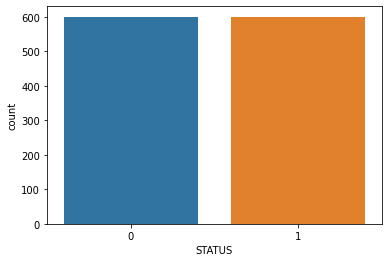

In [9]:
sns.countplot(df_tr, x='STATUS')

In [10]:
df_tr['STATUS'].mean()

0.5

### Treinamento e validação cruzada

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1995)

feature_importance_df = pd.DataFrame()

X = df_tr.drop(columns=['COD_CLI', 'STATUS', 'UF'])
y = df_tr['STATUS']

kf_results = {}
y_pred_oof = np.zeros(X.shape[0])

for i, (tr, ts) in enumerate(kf.split(X, y)):
    kf_results[i] = {}
    
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
    model = LogisticRegression(random_state=0)

    model.fit(Xtr, ytr)

    ypred = model.predict_proba(Xval)[:, 0]

    kf_results[i]['auroc'] = 1 - roc_auc_score(yval, ypred)

    y_pred_oof[ts] = ypred

df_tr['score'] = y_pred_oof * 1000

auroc = []

for _, results in kf_results.items():
    auroc.append(results.get('auroc'))
            
print("Média AUROC: {:.4f}".format(np.mean(auroc)))

Média AUROC: 0.7599


### Análise dos Resultados

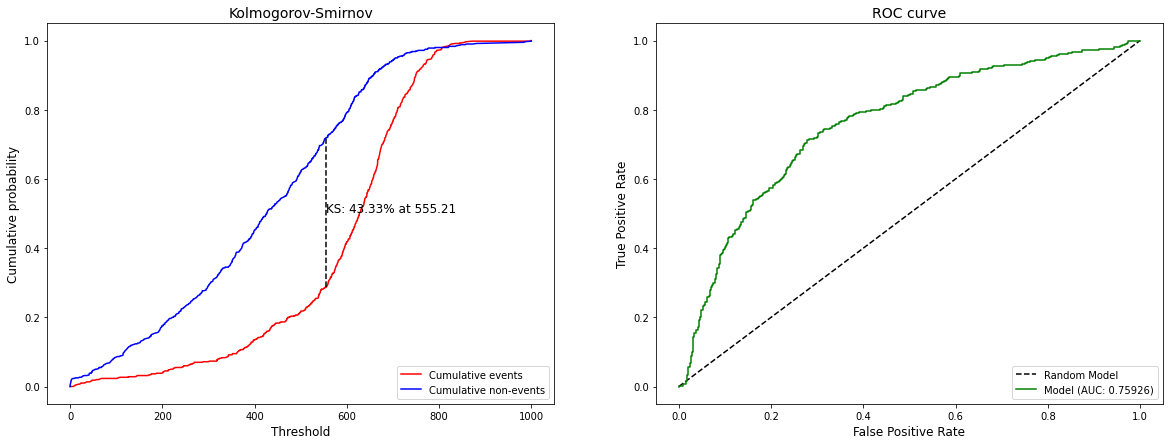

In [12]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
plot_ks(df_tr['STATUS'] * -1 + 1, df_tr['score'])

fig.add_subplot(122)
plot_auc_roc(df_tr['STATUS'] * -1 + 1, df_tr['score'])

<Axes: xlabel='score', ylabel='Count'>

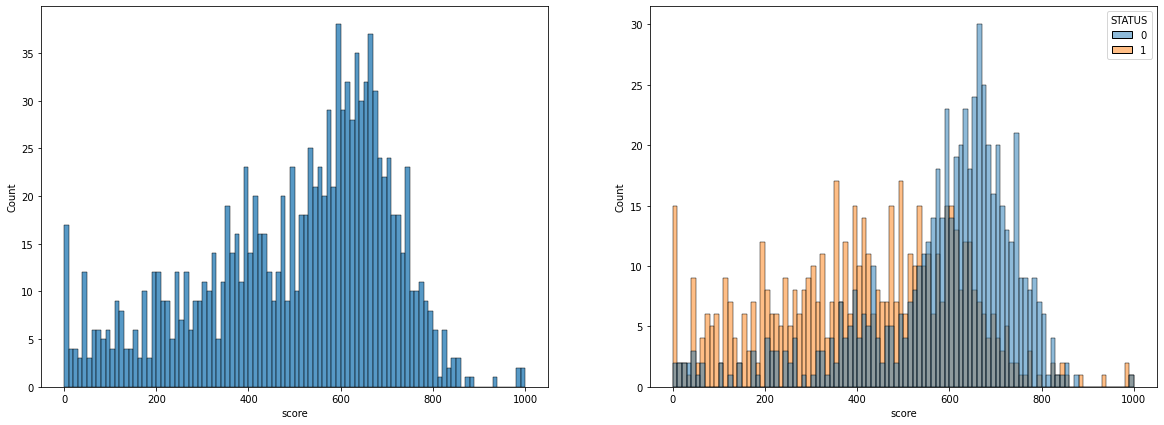

In [13]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.histplot(df_tr, x='score', bins=100)

fig.add_subplot(122)
sns.histplot(df_tr, x='score', hue='STATUS', bins=100)

## Teste do modelo

In [14]:
df_ts.fillna(df_tr.mean(), inplace=True)

In [15]:
X = df_tr.drop(columns=['COD_CLI', 'STATUS', 'UF', 'score'])
y = df_tr['STATUS']

model = LogisticRegression(random_state=0)

model.fit(X, y)

df_ts['score'] = model.predict_proba(df_ts[model.feature_names_in_])[:, 0] * 1000

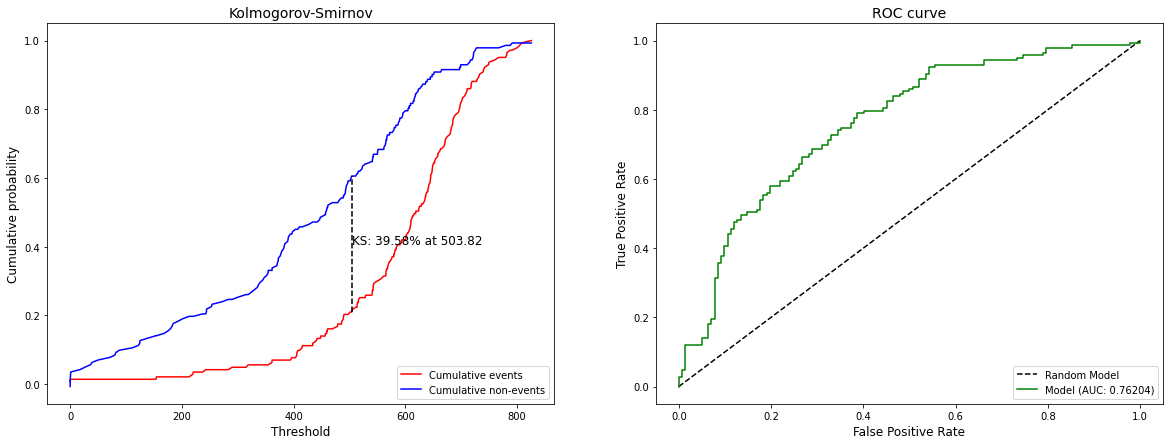

In [16]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
plot_ks(df_ts['STATUS'] * -1 + 1, df_ts['score'])

fig.add_subplot(122)
plot_auc_roc(df_ts['STATUS'] * -1 + 1, df_ts['score'])

<Axes: xlabel='score', ylabel='Count'>

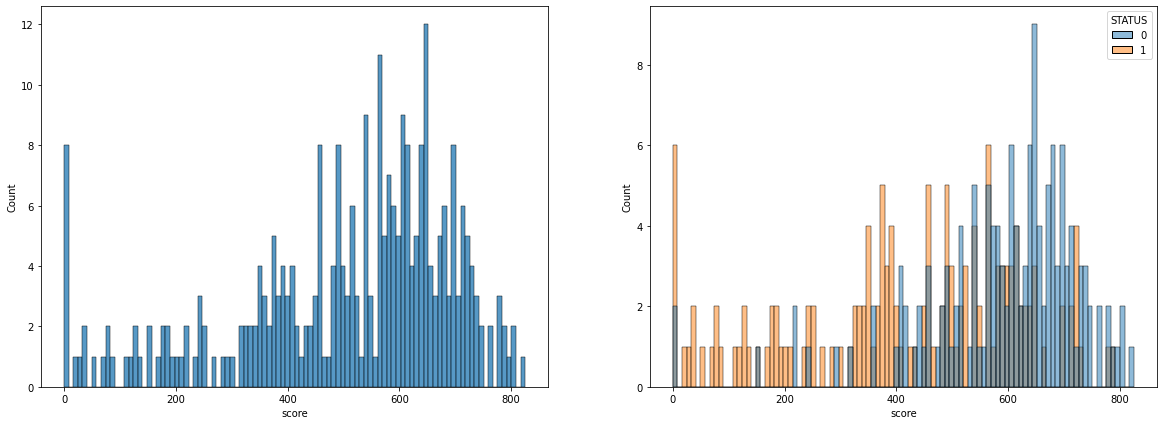

In [17]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.histplot(df_ts, x='score', bins=100)

fig.add_subplot(122)
sns.histplot(df_ts, x='score', hue='STATUS', bins=100)

### Treinamento final e validação

In [18]:
df_val.fillna(df_tr.mean(), inplace=True)

In [19]:
df_final = pd.concat([df_tr, df_ts])

In [20]:
X = df_final.drop(columns=['COD_CLI', 'STATUS', 'UF', 'score'])
y = df_final['STATUS']

model = LogisticRegression(random_state=0)

model.fit(X, y)

df_val['score'] = model.predict_proba(df_val[model.feature_names_in_])[:, 0] * 1000

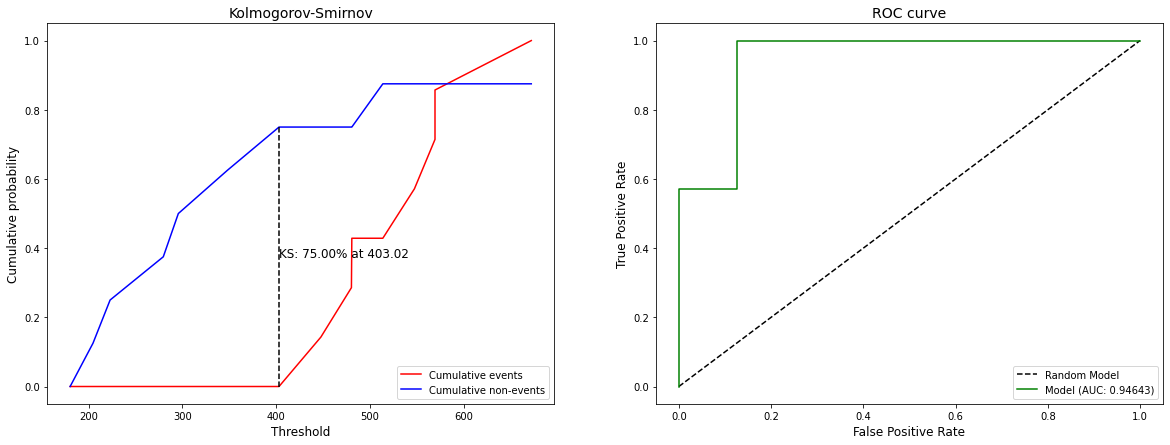

In [21]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
plot_ks(df_val['STATUS'] * -1 + 1, df_val['score'])

fig.add_subplot(122)
plot_auc_roc(df_val['STATUS'] * -1 + 1, df_val['score'])

<Axes: xlabel='score', ylabel='Count'>

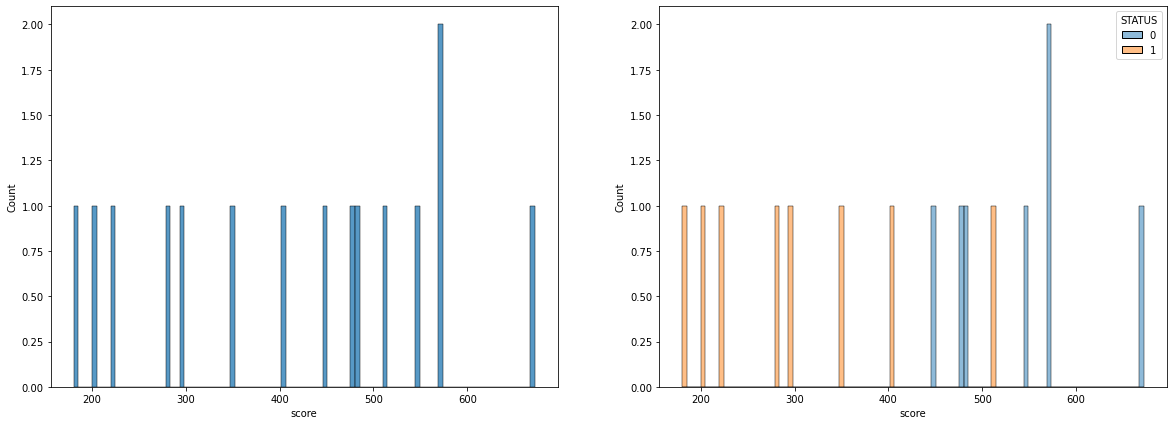

In [22]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.histplot(df_val, x='score', bins=100)

fig.add_subplot(122)
sns.histplot(df_val, x='score', hue='STATUS', bins=100)

In [23]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [24]:
df_val.to_csv('API_test.csv', index=False)